# Bastien GUILLOU and Ryan KHOU

# Chapter 7 - Exercises

> Author : Badr TAJINI - Large Language model (LLMs) - ESIEE 2024-2025

---


## Exercise 7.1: Changing prompt styles

**Prompt Style Comparative Analysis: Impact on Model Response Quality**

**Key Research Question: How do different prompt styles `(Alpaca vs. Phi-3)` influence the generative response quality of the `fine-tuned` model?**

*Methodological Approach:*
- `Fine-tune` model with `Alpaca` prompt style
- Apply `Phi-3 prompt` configuration
- Compare response quality metrics

*Critical Parameters:*
- Prompt style variations
- Response quality assessment
- Comparative performance evaluation

*Recommended Investigation:*
1. Implement Phi-3 prompt style `shown in figure 4 in chapter 7`
2. Evaluate response quality
3. Compare with `Alpaca` prompt results
4. Analyze observed variations



# Solution

1. Implement Phi-3 prompt style

In [1]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = ""

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
import torch

def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

To implement a Phi-3 prompt style (shown in figure 4 in chapter 7) we need to modify the format_input(entry)  function as follow :

In [3]:
def format_input_phi(entry):
    instruction_text = (
        f"<|user|>\n{entry['instruction']}"
    )

    input_text = f"\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

And modify InstructionDataset to implent this new way of format

In [4]:
import tiktoken
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            # previous answer
            # instruction_plus_input = format_input(entry)
            # response_text = f"\n\n### Response:\n{entry['output']}"

            # new response for a Phi-3 prompt style
            instruction_plus_input = format_input_phi(entry)
            response_text = f"\n<|assistant|>:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


In [5]:
from gpt_download import download_and_load_gpt2
from previous_labs import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


Then, we can train and test our model with this new prompt style

Initial losses
   Training loss: 3.686822700500488
   Validation loss: 3.644099569320679
Ep 1 (Step 000000): Train loss 2.633, Val loss 2.622
Ep 1 (Step 000005): Train loss 1.598, Val loss 1.461
Ep 1 (Step 000010): Train loss 1.196, Val loss 1.317
Ep 1 (Step 000015): Train loss 1.210, Val loss 1.273
Ep 1 (Step 000020): Train loss 1.078, Val loss 1.243
Ep 1 (Step 000025): Train loss 1.060, Val loss 1.208
Ep 1 (Step 000030): Train loss 1.128, Val loss 1.173
Ep 1 (Step 000035): Train loss 1.020, Val loss 1.142
Ep 1 (Step 000040): Train loss 0.962, Val loss 1.141
Ep 1 (Step 000045): Train loss 0.904, Val loss 1.123
Ep 1 (Step 000050): Train loss 0.923, Val loss 1.098
Ep 1 (Step 000055): Train loss 1.065, Val loss 1.077
Ep 1 (Step 000060): Train loss 1.018, Val loss 1.051
Ep 1 (Step 000065): Train loss 0.907, Val loss 1.037
Ep 1 (Step 000070): Train loss 0.763, Val loss 1.031
Ep 1 (Step 000075): Train loss 0.802, Val loss 1.040
Ep 1 (Step 000080): Train loss 0.842, Val loss 1.022
Ep 1 (Step

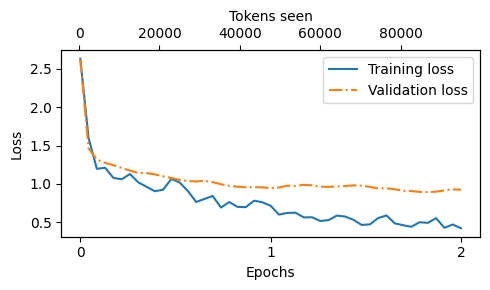

--------------------------------------------------


In [6]:
import time
import torch

from gpt_download import download_and_load_gpt2
from previous_labs import (
    calc_loss_loader,
    generate,
    GPTModel,
    load_weights_into_gpt,
    text_to_token_ids,
    train_model_simple,
    token_ids_to_text
)

from functools import partial
import tiktoken
from torch.utils.data import DataLoader

train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

batch_size = 8
num_workers = 0

model.to(device)

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

#######################################
# Finetuning the model
#######################################
print("Initial losses")
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("   Training loss:", train_loss)
print("   Validation loss:", val_loss)

start_time = time.time()

num_epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

torch.manual_seed(123)

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input_phi(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

from previous_labs import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
print(50*"-")

We generate our json file including instructions and answers in the format phi 3 prompt to evaluate the quality of the responses generated with ollama

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input_phi(entry)
    tokenizer=tokenizer

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("<|assistant|>:", "").strip()

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response-phi3-prompt.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

2. Evaluate response quality

In [10]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [11]:
import json
from tqdm import tqdm

file_path = "instruction-data-with-response-phi3-prompt.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input_phi(entry):
    instruction_text = (
        f"<|user|>\n{entry['instruction']}"
    )

    input_text = f"\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [12]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


In [13]:
from tqdm import tqdm

def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        if entry[json_key] == "":
            scores.append(0)
        else:
            prompt = (
                f"Given the input `{format_input_phi(entry)}` "
                f"and correct output `{entry['output']}`, "
                f"score the model response `{entry[json_key]}`"
                f" on a scale from 0 to 100, where 100 is the best score. "
                f"Respond with the integer number only."
            )
            score = query_model(prompt, model)
            try:
                scores.append(int(score))
            except ValueError:
                print(f"Could not convert score: {score}")
                continue

    return scores

model = "llama3"
scores = generate_model_scores(test_data, "model_response", model="llama3")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")


Scoring entries: 100%|██████████| 110/110 [04:33<00:00,  2.49s/it]

Number of scores: 110 of 110
Average score: 48.61



3. Compare with `Alpaca` prompt results

In [11]:
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [12]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [09:17<00:00,  5.07s/it]

Number of scores: 110 of 110
Average score: 50.01



For the phi3 format we have :

Number of scores: 110 of 110
Average score: 48.61

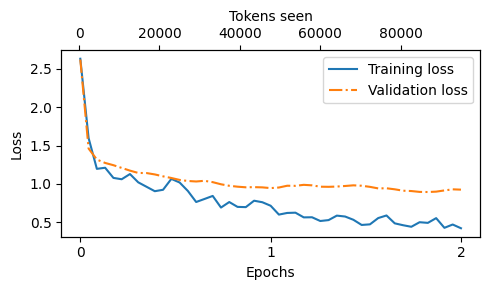

For the `Alpaca` prompt format we have :

Number of scores: 110 of 110
Average score: 50.01

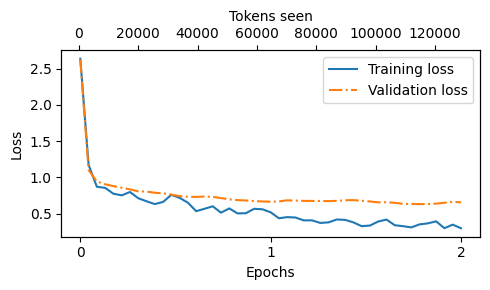

Both approaches show similar learning efficiency with significant reduction in loss values for training and validation over time. However, the model trained with the prompt Alpaca seems to generalize slightly better than that trained with the prompt Alpaca, reflected by a tighter convergence between training loss and validation.

The averages scores obtained are relatively similar, showing no particular interest in using the phi3 style against the Alpaca prompt format. 

4. Analyze observed variations

The differences observed in the slight differences obtained in our results are due to the format of the instructions sent to our model. For the Phi3 prompt format, the introductions included an additional section that had to be tokenizer for <|user|> and <|assistant|>, which can slightly disturb the model. However, the performance obtained is quite similar when it comes to the quality of the answers for these two formats. For better responsiveness to the Alapca prompt format when training GPT 2, it may be preferable to keep this prompt format. 

In addition, the model learning time was drastically reduced for the Alapca format with 0.88 minutes (in lab 7) compared to 4.83 minutes for the Phi3 format. Justifying this choice to prefer the format of prompt Alpaca.

&nbsp;
## Exercise 7.2: Instruction and input masking

**Instruction Masking Performance Evaluation**

**Key Research Question**: How does replacing instruction and input `tokens` with the `-100` mask impact model performance during fine-tuning?

*Methodological Approach:*
- Implement `-100` token masking for instructions
- Evaluate model performance
- Compare against standard fine-tuning approach

*Critical Parameters:*
- Instruction masking technique
- Performance assessment metrics
- Comparative analysis methodology

*Recommended Investigation:*
1. Apply `-100` mask to instruction and input `tokens`
2. Fine-tune model using `InstructionDataset`
3. Measure and compare performance metrics
4. Analyze potential learning improvements



# Solution

1. We need to apply -100 mask to instruction and input token. To do this we need to modify InstructionDataset and custom_collate_fn

We conserve the Alpaca prompt style

In [14]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [15]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        self.encoded_texts = []

        # Added to store the lengths of instructions separately
        self.instruction_lengths = []

        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            # Store encoded text
            self.encoded_texts.append(
                tokenizer.encode(full_text) 
            )
            # Encode and store the length of the instruction text only
            instruction_length = len(tokenizer.encode(instruction_plus_input))
            self.instruction_lengths.append(instruction_length)

    def __getitem__(self, index):
        # Modified to return both the length of the instruction and the encoded text
        return self.instruction_lengths[index], self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [19]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch, considering both instruction lengths and responses
    batch_max_length = max(len(item)+1 for instruction_length, item in batch)

    inputs_lst, targets_lst = [], []

    for instruction_length, item in batch:  # batch is now a tuple
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  
        targets = torch.tensor(padded[1:])  

        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # Mask out tokens in targets that correspond to the instruction portion
        targets[:instruction_length-1] = -100

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor


In [20]:
from gpt_download import download_and_load_gpt2
from previous_labs import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


2. Fine-tune model using `InstructionDataset`

Initial losses
   Training loss: 2.3913208484649657
   Validation loss: 2.2625606536865233
Ep 1 (Step 000000): Train loss 1.636, Val loss 1.620
Ep 1 (Step 000005): Train loss 1.060, Val loss 1.026
Ep 1 (Step 000010): Train loss 0.881, Val loss 0.939
Ep 1 (Step 000015): Train loss 0.878, Val loss 0.903
Ep 1 (Step 000020): Train loss 0.817, Val loss 0.878
Ep 1 (Step 000025): Train loss 0.737, Val loss 0.847
Ep 1 (Step 000030): Train loss 0.779, Val loss 0.825
Ep 1 (Step 000035): Train loss 0.645, Val loss 0.806
Ep 1 (Step 000040): Train loss 0.757, Val loss 0.804
Ep 1 (Step 000045): Train loss 0.564, Val loss 0.801
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.789
Ep 1 (Step 000055): Train loss 0.895, Val loss 0.786
Ep 1 (Step 000060): Train loss 0.670, Val loss 0.773
Ep 1 (Step 000065): Train loss 0.564, Val loss 0.759
Ep 1 (Step 000070): Train loss 0.523, Val loss 0.758
Ep 1 (Step 000075): Train loss 0.533, Val loss 0.753
Ep 1 (Step 000080): Train loss 0.561, Val loss 0.749
Ep 1 (St

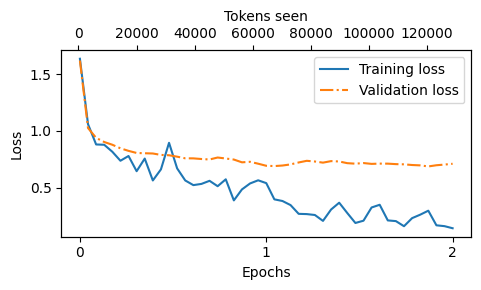

--------------------------------------------------


In [21]:
import time
import torch

from gpt_download import download_and_load_gpt2
from previous_labs import (
    calc_loss_loader,
    generate,
    GPTModel,
    load_weights_into_gpt,
    text_to_token_ids,
    train_model_simple,
    token_ids_to_text
)

from functools import partial
import tiktoken
from torch.utils.data import DataLoader
from previous_labs import plot_losses

train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

batch_size = 8
num_workers = 0

model.to(device)

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

#######################################
# Finetuning the model
#######################################
print("Initial losses")
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("   Training loss:", train_loss)
print("   Validation loss:", val_loss)

start_time = time.time()

num_epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

torch.manual_seed(123)

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input_phi(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
print(50*"-")

In [22]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)
    tokenizer=tokenizer

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("<|assistant|>:", "").strip()

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response-input-masking.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [06:38<00:00,  3.62s/it]


3. Measure and compare performance metrics

In [23]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [24]:
import json
from tqdm import tqdm

file_path = "instruction-data-with-response-input-masking.json"

with open(file_path, "r") as file:
    test_data = json.load(file)

In [25]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


In [27]:
from tqdm import tqdm

def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")


Scoring entries: 100%|██████████| 110/110 [04:19<00:00,  2.36s/it]

Number of scores: 110 of 110
Average score: 47.77



For the initial `Alpaca` prompt format with the Instruction and input not masking we have :

Number of scores: 110 of 110
Average score: 50.01

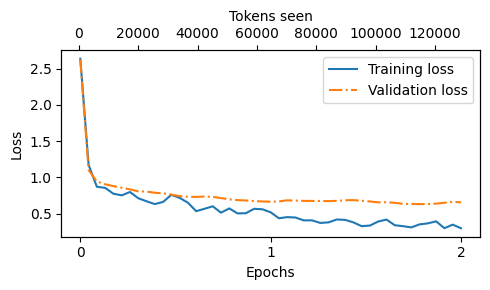


The loss graph shows that the loss of training and validation drops rapidly at the beginning of training, then stabilizes. The divergence between loss of validation and loss of training is minimal throughout the ages, indicating that the model is generalizing effectively without overfitting.

Now for the `Alpaca` prompt format with the Instruction and input masking we have :

Number of scores: 110 of 110
Average score: 47.77

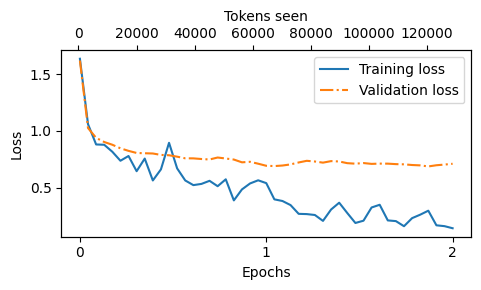

The loss of training also decreases rapidly, while the loss of validation is a little more unstable and tends to be slightly higher than that of the loss of training throughout the ages. This could indicate a slight overfit or that the model is not easy to generalize.


Instruction and input masking seems to slightly reduce the model’s ability to generalize, induced by a decrease in the average score and a more unstable loss of validation. Leading to the belief that masking complicates the task for the model, perhaps by limiting access to some key information during training that is necessary for better prediction.

4. Analyze potential learning improvements

To improve learning by using the method of masking instructions and data, we could: 

- Adjust hyperparmeter models: learning rate, batch size and regularization.
- Partial or conditional masking: only hide certain elements of the instructions or do it conditionally, depending on the complexity of the instruction. 
- Use more data: increase diversity of data and achieve better results. 

&nbsp;
## Exercise 7.3: Finetuning on the original Alpaca dataset

**Large-Scale Instruction Dataset Fine-Tuning: Computational and Methodological Considerations**

The Alpaca dataset, a significant instruction dataset created by Stanford researchers. With 52,002 entries, this dataset is notably larger than the previously mentioned instruction-data.json file. The text provides recommendations for fine-tuning a Large Language Model (LLM) using this dataset.

**Key Research Question: How can one effectively fine-tune an LLM using the Alpaca dataset while managing computational resources and potential memory constraints?**

**Link to download the Alpaca dataset**:  [here](https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json).

*Methodological Approach:*
- Analyze Alpaca dataset characteristics
- Develop GPU-accelerated fine-tuning strategy
- Implement computational optimization techniques

*Critical Parameters:*
- Dataset scale (52,002 entries)
- Computational resource management
- Fine-tuning performance optimization

*Computational Optimization Strategies:*
- Batch size reduction (`batch_size`)
- Maximum sequence length adjustment
- GPU resource utilization

*Recommended Investigation:*
1. Load and prepare Alpaca dataset
2. Implement adaptive fine-tuning approach
3. Address potential memory constraints
4. Optimize computational performance

*Key Mitigation Techniques:
- Reduce `batch_size` (8 → 4 → 2 → 1)
- Truncate `allowed_max_length` (1,024 → 512 → 256)
- Leverage GPU computational capabilities

1. Load and prepare Alpaca dataset

In [56]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r") as file:
        data = json.load(file)

    return data


file_path = "instruction-data-52k.json"
url = "https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json"

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 52002


2. Implement adaptive fine-tuning approach

The power used for the GPU does not allow to train the model with the 52k instruction dataset, because the learning times are very long (several hours). Thus only code and potential interpretation are given.

In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [ ]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [ ]:
from gpt_download import download_and_load_gpt2
from previous_labs import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


In [ ]:
import time
import torch

from gpt_download import download_and_load_gpt2
from previous_labs import (
    calc_loss_loader,
    generate,
    GPTModel,
    load_weights_into_gpt,
    text_to_token_ids,
    train_model_simple,
    token_ids_to_text
)

from functools import partial
import tiktoken
from torch.utils.data import DataLoader
from previous_labs import plot_losses

train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

batch_size = 8
num_workers = 0

model.to(device)

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

#######################################
# Finetuning the model
#######################################
print("Initial losses")
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("   Training loss:", train_loss)
print("   Validation loss:", val_loss)

start_time = time.time()

num_epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

torch.manual_seed(123)

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input_phi(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
print(50*"-")

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)
    tokenizer=tokenizer

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)

    response_text = generated_text[len(input_text):].replace("<|assistant|>:", "").strip()

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response-input-masking.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

3. Measure and compare performance metrics

In [ ]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [ ]:
import json
from tqdm import tqdm

file_path = "instruction-data-with-response-input-masking.json"

with open(file_path, "r") as file:
    test_data = json.load(file)

In [ ]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


In [ ]:
from tqdm import tqdm

def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")


3. Address potential memory constraints

When fine-tuning the data set using Alpaca, it is crucial to take into account the potential memory constraints due to its considerable size (52,002 entries). An adaptive fine-tuning approach is needed to manage resources efficiently while maximizing performance. An iterative approach to reduce the batch size (batch_size) from 8 to 1, while adjusting the maximum sequence length (allowed_max_length) from 1.024 to 256, would reduce the load on memory while exploiting the computing capabilities of GPUs. This approach facilitates efficient resource use while preventing capacity overruns, which is crucial for managing a high amount of data.

However, these can not be tested on the required computational capabilities. 

4. Optimize computational performance

Since we cannot try to learn this model from this type of dataset, the methods mentioned above cannot be tried. However, it is clear that the latter could help the computational speed of learning the model, probably to the slightly reduced performance trimmer. 